In [60]:
import sys
# sys.path.append("../..")
# sys.path.insert(1, 'C:/Users/isrqa/ELIopt-main/ELIopt-main/algorithms')
from bayes_opt import BayesianOptimization
from L1_DifferentialEvolution import extract_data, model, diff_evolution
import physics
from losses import Losses
from scipy.optimize import Bounds
from scipy.optimize import minimize
from pyswarm import pso
import numpy as np
import matplotlib.pyplot as plt

In [61]:
frequency, intensity = extract_data() # extracting the desired information

# compressor parameters - obtained as minus the stretcher one - TO BE FIXED WITH REAL ONES ONCE THEY ARE AVAILABLE
COMPRESSOR = -1 * np.array((267.422 * 1e-24, -2.384 * 1e-36, 9.54893 * 1e-50)) # in s^2, s^3 and s^4 (SI units)
# non linearity parameter
B = 2
# cutoff frequencies, in THz, used to remove noise - derived from visual inspection
CUTOFF = (289.95, 291.91)
# model instantiation
l1_pump = model(frequency, intensity, COMPRESSOR, B, CUTOFF, num_points=int(5e3))

losses = Losses(l1_pump)

bounds_DE = Bounds(
            # GDD         # TOD          # FOD
    lb = (2.3522e-22, -1.003635e-34, 4.774465e-50),
    ub = (2.99624e-22, 9.55955e-35, 1.4323395e-49)
)

bounds_matrix = np.vstack((bounds_DE.lb, bounds_DE.ub)).T
disp_bounds = np.sort(l1_pump.translate_control(bounds_matrix, verse = "to_disp"))

In [62]:
def outer_objfunc(mutation:float, cross_p:float, population_size:float) -> float: 
    """
    This is the outher objective function which is taking as input values characteristic of the 
    optimisation process.
    For further documentantion on the relevance of these parameters and their effect on the optimisation 
    route check literature.
    """
    population_size = int(population_size) # must be int
    
    candidate_best = diff_evolution(
        objective_function = losses.loss3,
        bounds = disp_bounds,
        mutation = mutation, 
        cross_p = cross_p, 
        population_size = population_size,
        verbose = 0, 
        maxit = 500, 
        print_every = 50
    )
    
    return -1 * losses.loss3(candidate_best) # maximizing

In [5]:
params_bounds = {
    "mutation": (0.5, 1.99), 
    "cross_p": (0, 1), 
    "population_size": (10, 50)
}

optimizer = BayesianOptimization(
    f = outer_objfunc, 
    pbounds = params_bounds, 
    random_state = 10, 
    verbose = 1
)

n_init, n_iter = 20, 100
optimizer.maximize(init_points = n_init, n_iter = n_iter)


|   iter    |  target   |  cross_p  | mutation  | popula... |
-------------------------------------------------------------
|  2        | -1.443    |  0.7488   |  1.243    |  18.99    |
|  46       | -1.443    |  0.8284   |  0.5616   |  21.67    |


In [57]:
lb = [-5.31305788e-01, -3.14772231e+08, -2.55151879e+15]
ub = [-4.17101926e-01, 3.01620182e+08, 1.56859005e+15]

# lb = (2.3522e-22, -1.003635e-34, 4.774465e-50),
#     ub = (2.99624e-22, 9.55955e-35, 1.4323395e-49)
# [-4.75711318e-01 -7.00593523e+06  2.45034510e+15]

# [-5.31305788e-01, -4.17101926e-01],
#        [-3.14772231e+08,  3.01620182e+08],
#        [-2.55151879e+15,  1.56859005e+15]

# start = timeit.default_timer()
xopt, fopt = pso(losses.loss3, lb, ub, swarmsize=100, debug=True, maxiter=10)

# xopt, fopt = pso(losses.loss3, lb, ub, swarmsize=200, omega=0.5, phip=0.5, phig=0.5, maxiter=60, minstep=1e-7,
#     minfunc=1e-15, debug=True)

# stop = timeit.default_timer()

# print('Time: ', stop - start) 

No constraints given.
New best for swarm at iteration 1: [-4.67424465e-01 -4.83925577e+07 -2.28291407e+15] 37.187749886718954
New best for swarm at iteration 1: [-4.74897105e-01  1.32195292e+07 -1.98866345e+15] 31.043081169591748
Best after iteration 1: [-4.74897105e-01  1.32195292e+07 -1.98866345e+15] 31.043081169591748
New best for swarm at iteration 2: [-4.83417760e-01  1.25055007e+07 -2.55151879e+15] 20.353289609310664
New best for swarm at iteration 2: [-4.77011091e-01 -8.97939220e+06  1.56859005e+15] 7.149284041668991
Best after iteration 2: [-4.77011091e-01 -8.97939220e+06  1.56859005e+15] 7.149284041668991
Best after iteration 3: [-4.77011091e-01 -8.97939220e+06  1.56859005e+15] 7.149284041668991
New best for swarm at iteration 4: [-4.74484727e-01 -7.90602755e+06  1.07245677e+15] 6.6789431356373266
Best after iteration 4: [-4.74484727e-01 -7.90602755e+06  1.07245677e+15] 6.6789431356373266
Best after iteration 5: [-4.74484727e-01 -7.90602755e+06  1.07245677e+15] 6.6789431356373

In [58]:
rsult = minimize(losses.loss3, xopt, method='Nelder-Mead')

print('Status : %s' % rsult['message'])
print('Total Evaluations: %d' % rsult['nfev'])
solution = rsult['x']
evaluation = losses.loss3(solution)
print('Solution: f(%s) = %.5f' % (solution, evaluation))
print('(RMSE)',losses.loss3(solution))

Status : Optimization terminated successfully.
Total Evaluations: 406
Solution: f([-4.75711318e-01 -7.00593521e+06  2.45034507e+15]) = 1.36228
(RMSE) 1.3622757674017347


In [63]:
cross_p, mutation, pop_size = optimizer.max["params"].values()
# training with the best parameters and increased number of iterations
candidate_best = diff_evolution(
        objective_function = losses.loss3,
        bounds = disp_bounds,
        mutation = mutation, 
        cross_p = cross_p, 
        population_size = int(pop_size),
        verbose = 1, 
        maxit = 100, 
        print_every = 50
)

Iteration 0 - Objective Function value: 29.093177844935425
Iteration 50 - Objective Function value: 1.4433561261691674


In [64]:
rsult = minimize(losses.loss3, candidate_best, method='Nelder-Mead')

print('Status : %s' % rsult['message'])
print('Total Evaluations: %d' % rsult['nfev'])
solution = rsult['x']
# evaluation = rmse(solution)
evaluation = losses.loss3(solution)
print('Solution: f(%s) = %.5f' % (solution, evaluation))
# print('(RMSE)',rmse(solution))
print('(RMSE)',losses.loss3(solution))
# candidate_best = solution

Status : Maximum number of function evaluations has been exceeded.
Total Evaluations: 600
Solution: f([-4.75711318e-01 -7.00593518e+06  2.45034508e+15]) = 1.36228
(RMSE) 1.3622757674017627


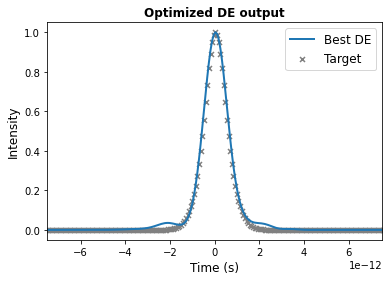

In [65]:
candidate_best = solution
time, profile = l1_pump.forward_pass(candidate_best)
fig, ax = plt.subplots()

ax.set_title("Optimized DE output", fontweight = "bold")
ax.scatter(losses.target_time, losses.target_profile, marker = "x", c = "grey", s = 25, label = "Target")
ax.plot(losses.target_time, np.roll(profile, - np.argmax(profile) + np.argmax(losses.target_profile)), label = "Best DE", lw = 2)

ax.set_xlim(-7.5e-12, 7.5e-12); ax.set_xlabel("Time (s)", fontsize = 12); ax.set_ylabel("Intensity", fontsize = 12)
ax.legend(fontsize = 12)
plt.show()